In [1]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages

### LDL-Validation
- Need to confirm branch prior to working 
- Run on 8/25/22, pulled today 
- Working on validation and verification of LDL-C 

## Load in Data and First Time Step

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 50_000,
                               'age_end': 50,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

#BMI exposure or effect (RR or too high BMIs) 
#Could look at the median instead of the mean 
#Incidence hazard rate for the simulant and on average should match the artifact value 

2023-03-22 07:01:41.130 | DEBUG    | vivarium.framework.values:register_value_modifier:392 - Registering metrics.1.population_manager.metrics as modifier to metrics
2023-03-22 07:01:41.273 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:66 - Running simulation from artifact located at /ihme/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-03-22 07:01:41.274 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:67 - Artifact base filter terms are ['draw == 0'].
2023-03-22 07:01:41.282 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:68 - Artifact additional filter terms are None.
2023-03-22 07:01:41.663 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline cause_specific_mortality_rate
2023-03-22 07:01:41.664 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline mortality_rate
2023-03-22 07:01:42.149 | DEBUG    | vivarium.framework.values:_regis

In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,exit_time,age,alive,sex,entrance_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,sbp_multiplier,ldlc_medication,ldlc_medication_adherence,outreach,polypill,sbp_medication,sbp_medication_adherence,ldlc_multiplier,scheduled_date,visit_type
0,True,NaT,32.352874,alive,Female,2020-12-04,Alabama,not_dead,0.0,0.0,...,1.0,no_treatment,cat1,cat2,cat2,no_treatment,cat3,1.0,NaT,none
1,True,NaT,26.570269,alive,Male,2020-12-04,Alabama,not_dead,0.0,0.0,...,1.0,no_treatment,cat1,cat2,cat2,no_treatment,cat3,1.0,NaT,none
2,True,NaT,38.102882,alive,Female,2020-12-04,Alabama,not_dead,0.0,0.0,...,1.0,no_treatment,cat1,cat2,cat2,no_treatment,cat3,1.0,NaT,none
3,True,NaT,20.470149,alive,Male,2020-12-04,Alabama,not_dead,0.0,0.0,...,1.0,no_treatment,cat2,cat2,cat2,no_treatment,cat3,1.0,NaT,none
4,True,NaT,14.560959,alive,Female,2020-12-04,Alabama,not_dead,0.0,0.0,...,1.0,no_treatment,cat3,cat2,cat2,no_treatment,cat3,1.0,NaT,none


In [5]:
pop0.columns

Index(['tracked', 'exit_time', 'age', 'alive', 'sex', 'entrance_time',
       'location', 'cause_of_death', 'years_of_life_lost',
       'years_lived_with_disability', 'previous_ischemic_stroke',
       'previous_ischemic_heart_disease_and_heart_failure',
       'sbp_medication_adherence_propensity',
       'ldlc_medication_adherence_propensity', 'outreach_propensity',
       'polypill_propensity', 'ischemic_stroke',
       'ischemic_heart_disease_and_heart_failure',
       'high_ldl_cholesterol_propensity',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'high_systolic_blood_pressure_propensity',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'high_body_mass_index_in_adults_propensity',
       'ensemble_propensity_risk_factor.high_body_mass_index_in_adults',
       'high_fasting_plasma_glucose_propensity',
       'ensemble_propensity_risk_factor.high_fasting_plasma_glucose',
       'susceptible_to_ischemic_stroke_event_count',
     

In [6]:
sim.list_values()

['metrics',
 'cause_specific_mortality_rate',
 'mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate.paf',
 'disability_weight',
 'sbp_medication_adherence.propensity',
 'sbp_medication_adherence.exposure',
 'risk_factor.sbp_medication_adherence.exposure_parameters',
 'ldlc_medication_adherence.propensity',
 'ldlc_medication_adherence.exposure',
 'risk_factor.ldlc_medication_adherence.exposure_parameters',
 'outreach.propensity',
 'outreach.exposure',
 'risk_factor.outreach.exposure_parameters',
 'risk_factor.outreach.exposure_parameters.paf',
 'polypill.propensity',
 'polypill.exposure',
 'risk_factor.polypill.exposure_parameters',
 'risk_factor.polypill.exposure_parameters.paf',
 'high_ldl_cholesterol.exposure',
 'acute_myocardial_infarction.incidence_rate',
 'acute_myocardial_infarction.incidence_rate.paf',
 'post_myocardial_infarction_to_acute_myocardial_infarction.transition_rate',
 'post_myocardial_infarction_to_

In [7]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl_cholesterol'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('acute_mi'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate')(pop0.index).rename('acute_stroke'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('bmi_propensity'),
                  ], axis=1)
data1.head()

,tracked,exit_time,age,alive,sex,entrance_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,sbp_medication_adherence,ldlc_multiplier,scheduled_date,visit_type,high_ldl_cholesterol,high_sbp,high_bmi,acute_mi,acute_stroke,bmi_propensity
0,True,NaT,32.352874,alive,Female,2020-12-04,Alabama,not_dead,0.0,0.0,...,cat3,1.0,NaT,none,2.816366,109.351460,34.380091,0.000007,0.000003,0.654379
1,True,NaT,26.570269,alive,Male,2020-12-04,Alabama,not_dead,0.0,0.0,...,cat3,1.0,NaT,none,4.859210,109.591919,31.007299,0.000006,0.000002,0.718453
2,True,NaT,38.102882,alive,Female,2020-12-04,Alabama,not_dead,0.0,0.0,...,cat3,1.0,NaT,none,3.497797,120.234550,6.567555,0.000012,0.000004,0.026993
3,True,NaT,20.470149,alive,Male,2020-12-04,Alabama,not_dead,0.0,0.0,...,cat3,1.0,NaT,none,0.000000,50.000000,37.132070,0.000020,0.000005,0.839638
4,True,NaT,14.560959,alive,Female,2020-12-04,Alabama,not_dead,0.0,0.0,...,cat3,1.0,NaT,none,0.000000,50.000000,5.000000,0.000000,0.000007,0.954183


In [8]:
len(data1.loc[(data1.age > 25) & (data1.age < 35) & (data1.alive == 'alive') & (data1.bmi_propensity > 0.98) & (data1.sex == 'Female')])/len(data1.loc[(data1.age > 25) & (data1.age < 35) & (data1.alive == 'alive') & (data1.sex == 'Female')])

0.01893939393939394

In [9]:
len(data1.loc[(data1.age > 25) & (data1.alive == 'alive') & (data1.high_bmi > 45)])/len(data1.loc[(data1.age > 25) & (data1.alive == 'alive')])

0.08422648792087398

In [10]:
len(data1.loc[(data1.age > 25) & (data1.alive == 'alive') & (data1.high_bmi > 50)])/len(data1.loc[(data1.age > 25) & (data1.alive == 'alive')])

0.042940345314815456

In [11]:
len(data1.loc[(data1.age > 25) & (data1.alive == 'alive') & (data1.high_bmi > 55)])/len(data1.loc[(data1.age > 25) & (data1.alive == 'alive')])

0.023227763035461972

In [12]:
len(data1.loc[(data1.age > 25) & (data1.alive == 'alive') & (data1.high_bmi > 60)])/len(data1.loc[(data1.age > 25) & (data1.alive == 'alive')])

0.012716683323568942

In [13]:
len(data1.loc[(data1.age > 25) & (data1.alive == 'alive') & (data1.high_bmi == 80)])/len(data1.loc[(data1.age > 25) & (data1.alive == 'alive')])

0.0012751145880001379

In [14]:
len(data1.loc[(data1.age > 25) & (data1.alive == 'alive') & (data1.high_sbp > 150)])/len(data1.loc[(data1.age > 25) & (data1.alive == 'alive')])

0.01275114588000138

In [15]:
len(data1.loc[(data1.age > 25) & (data1.alive == 'alive') & (data1.high_sbp > 160)])/len(data1.loc[(data1.age > 25) & (data1.alive == 'alive')])

0.004169969328324775

In [16]:
len(data1.loc[(data1.age > 25) & (data1.alive == 'alive') & (data1.high_sbp > 200)])/len(data1.loc[(data1.age > 25) & (data1.alive == 'alive')])

0.00024123789502705312

In [10]:
data1.loc[(data1.age > 25) & (data1.age < 35) & (data1.alive == 'alive') & (data1.high_bmi == 80)]

,tracked,location,age,sex,entrance_time,exit_time,alive,years_of_life_lost,cause_of_death,years_lived_with_disability,...,ldlc_medication_adherence,sbp_medication_adherence,scheduled_date,visit_type,high_ldl_cholesterol,high_sbp,high_bmi,acute_mi,acute_stroke,bmi_propensity
436,True,Alabama,30.705852,Female,2020-12-04,NaT,alive,0.0,not_dead,0.0,...,cat3,cat3,NaT,none,2.558673,117.346041,80.0,0.008886,0.005827,0.996625
3319,True,Alabama,33.930696,Female,2020-12-04,NaT,alive,0.0,not_dead,0.0,...,cat3,cat1,NaT,none,3.600888,117.838104,80.0,0.019128,0.008947,0.997544
12591,True,Alabama,31.540502,Male,2020-12-04,NaT,alive,0.0,not_dead,0.0,...,cat3,cat1,NaT,none,3.249511,120.805950,80.0,0.014805,0.004938,0.995746
15360,True,Alabama,25.326992,Male,2020-12-04,NaT,alive,0.0,not_dead,0.0,...,cat3,cat3,NaT,none,2.902548,112.961811,80.0,0.489679,0.006409,0.999018
21081,True,Alabama,33.625753,Female,2020-12-04,NaT,alive,0.0,not_dead,0.0,...,cat2,cat3,NaT,none,3.088696,111.512021,80.0,0.009576,0.005526,0.998024
32739,True,Alabama,27.394659,Female,2020-12-04,NaT,alive,0.0,not_dead,0.0,...,cat3,cat3,NaT,none,2.929668,99.904703,80.0,0.399924,0.007929,0.998779
33421,True,Alabama,27.960037,Female,2020-12-04,NaT,alive,0.0,not_dead,0.0,...,cat3,cat3,NaT,none,2.193009,113.405646,80.0,0.255421,0.006459,0.995091
36284,True,Alabama,34.039622,Female,2020-12-04,NaT,alive,0.0,not_dead,0.0,...,cat1,cat3,NaT,none,1.226899,117.184790,80.0,0.003434,0.003454,0.998679
36911,True,Alabama,32.174773,Female,2020-12-04,NaT,alive,0.0,not_dead,0.0,...,cat3,cat3,NaT,none,2.012089,110.250907,80.0,0.004476,0.003646,0.995465
37140,True,Alabama,27.030777,Male,2020-12-04,NaT,alive,0.0,not_dead,0.0,...,cat1,cat3,NaT,none,2.958216,110.945787,80.0,0.492625,0.006365,0.998363


In [11]:
data_25_f = data1.loc[(data1.age > 25) & (data1.age < 35) & (data1.alive == 'alive') & (data1.sex == 'Female')]

In [12]:
data_25 = data1.loc[(data1.age > 25)]

(array([ 328., 2842., 8680., 8647., 5058., 2216.,  753.,  314.,   95.,
          84.]),
 array([ 5. , 12.5, 20. , 27.5, 35. , 42.5, 50. , 57.5, 65. , 72.5, 80. ]),
 <BarContainer object of 10 artists>)

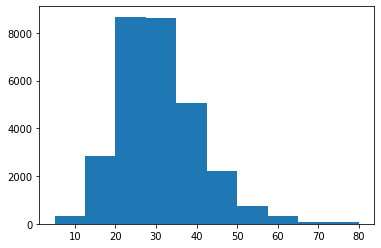

In [13]:
plt.hist(data_25.high_bmi)

(array([  51.,  501., 1689., 1831., 1150.,  537.,  195.,   77.,   21.,
          20.]),
 array([ 5. , 12.5, 20. , 27.5, 35. , 42.5, 50. , 57.5, 65. , 72.5, 80. ]),
 <BarContainer object of 10 artists>)

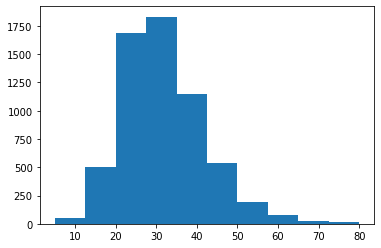

In [14]:
plt.hist(data_25_f.high_bmi)

In [11]:
len(data1.loc[(data1.age > 25) & (data1.age < 35) & (data1.alive == 'alive') & (data1.high_bmi > 80)])

0

In [12]:
len(data1.loc[(data1.age > 35) & (data1.age < 45) & (data1.alive == 'alive') & (data1.high_bmi > 80)])

0

In [15]:
len(data1.loc[(data1.age > 25) & (data1.age < 35) & (data1.alive == 'alive') & (data1.high_bmi > 40)])

2016

In [18]:
len(data1.loc[(data1.age > 25) & (data1.age < 35) & (data1.alive == 'alive')])

12204

In [19]:
2016/12204

0.16519174041297935

In [20]:
len(data1.loc[(data1.age > 25) & (data1.age < 35) & (data1.alive == 'alive') & (data1.sex == 'Female') & (data1.high_bmi > 40)])

1155

In [21]:
len(data1.loc[(data1.age > 25) & (data1.age < 35) & (data1.alive == 'alive') & (data1.sex == 'Female')])

6072

In [22]:
1155/6072

0.19021739130434784

## Standard Deviation Testing
### For LDL-C First

#### Load in the Artifact

In [24]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [25]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

In [21]:
ldl_exp_std = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure_standard_deviation')
ldl_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_exp_std.age_start,ldl_exp_std.age_end)]
ldl_exp_std.head()

/tmp/ipykernel_4162104/881126595.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.770720,0.739939,0.802223,Alabama,exposure_standard_deviation,25_to_29
1,female,30.0,35.0,2019,2020,0.760812,0.726483,0.795325,Alabama,exposure_standard_deviation,30_to_34
2,female,35.0,40.0,2019,2020,0.796737,0.761689,0.828880,Alabama,exposure_standard_deviation,35_to_39
3,female,40.0,45.0,2019,2020,0.795283,0.761479,0.829430,Alabama,exposure_standard_deviation,40_to_44
4,female,45.0,50.0,2019,2020,0.841080,0.813876,0.871734,Alabama,exposure_standard_deviation,45_to_49


In [22]:
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
data1_std = (data1
                .groupby(['age_start', 'sex'])
                .high_ldl_cholesterol.describe()
                .filter(['std'])
                .reset_index())
data1_std = data1_std.loc[data1_std['age_start'] > 20]
data1_std.head()

,age_start,sex,std
8,25.0,Female,0.819491
9,25.0,Male,0.798370
10,30.0,Female,0.802256
11,30.0,Male,0.799658
12,35.0,Female,0.835851


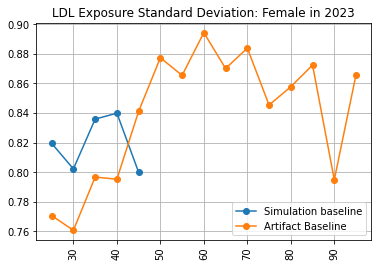

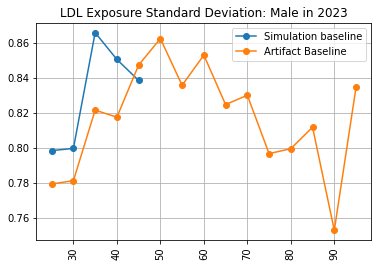

In [23]:
for sex in data1_std.sex.unique():
    plt.figure() 
    subdata = data1_std.loc[(data1_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = ldl_exp_std.loc[(ldl_exp_std.sex==sex.lower()) & (ldl_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    #plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL Exposure Standard Deviation: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Artifact 95%']) 

The standard deviation looks pretty good here! 

### Now for SBP

In [24]:
sbp_exp_std = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure_standard_deviation')
sbp_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_exp_std.age_start,sbp_exp_std.age_end)]
sbp_exp_std.head()

/tmp/ipykernel_4162104/881126595.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,8.022403,7.906046,8.148412,Alabama,exposure_standard_deviation,25_to_29
1,female,30.0,35.0,2019,2020,9.180372,9.047262,9.325224,Alabama,exposure_standard_deviation,30_to_34
2,female,35.0,40.0,2019,2020,10.330872,10.176664,10.481475,Alabama,exposure_standard_deviation,35_to_39
3,female,40.0,45.0,2019,2020,11.285085,11.106778,11.458061,Alabama,exposure_standard_deviation,40_to_44
4,female,45.0,50.0,2019,2020,13.460227,13.277262,13.656248,Alabama,exposure_standard_deviation,45_to_49


In [25]:
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
data1_std = (data1
                .groupby(['age_start', 'sex'])
                .high_sbp.describe()
                .filter(['std'])
                .reset_index())
data1_std = data1_std.loc[data1_std['age_start'] > 20]
data1_std.head()

,age_start,sex,std
8,25.0,Female,7.978439
9,25.0,Male,8.262777
10,30.0,Female,10.487574
11,30.0,Male,9.598972
12,35.0,Female,10.168698


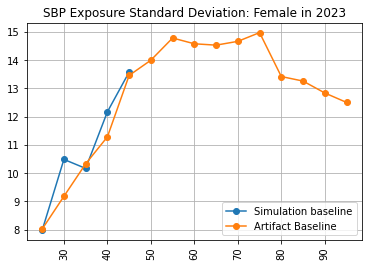

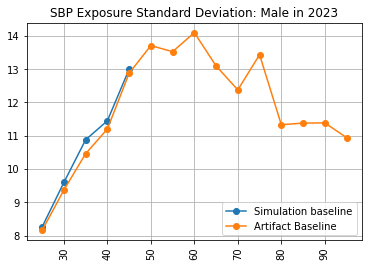

In [26]:
for sex in data1_std.sex.unique():
    plt.figure() 
    subdata = data1_std.loc[(data1_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = sbp_exp_std.loc[(sbp_exp_std.sex==sex.lower()) & (sbp_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    #plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure Standard Deviation: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Artifact 95%']) 

A little funky at the start but I would guess this is due to very small numbers at the youngest age groups. Overall this looks fine.

### Lastly, BMI

In [26]:
bmi_exp_std = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure_standard_deviation')
bmi_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_exp_std.age_start,bmi_exp_std.age_end)]
bmi_exp_std.head()

/tmp/ipykernel_1875287/881126595.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,8.717997,5.364839,10.205798,Alabama,exposure_standard_deviation,25_to_29
1,female,30.0,35.0,2019,2020,8.549725,5.517891,10.565673,Alabama,exposure_standard_deviation,30_to_34
2,female,35.0,40.0,2019,2020,8.799174,5.578608,10.528133,Alabama,exposure_standard_deviation,35_to_39
3,female,40.0,45.0,2019,2020,8.560564,5.575982,10.761351,Alabama,exposure_standard_deviation,40_to_44
4,female,45.0,50.0,2019,2020,8.688726,5.610063,10.831001,Alabama,exposure_standard_deviation,45_to_49


In [28]:
data = art.load('risk_factor.high_body_mass_index_in_adults.exposure_standard_deviation')
data = data.rename(columns={"draw_0": "bmi_std"}).reset_index()
data = data.rename(columns={"draw_1": "bmi_std_2"}).reset_index()
data['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(data.age_start,data.age_end)]
#data
#data['location'] = i.capitalize()
#data['measure'] = measure
#data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')


In [29]:
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
data1_std = (data1
                .groupby(['age_start', 'sex'])
                .high_bmi.describe()
                .filter(['std'])
                .reset_index())
data1_std = data1_std.loc[data1_std['age_start'] > 20]
data1_std.head()

#Is the orange a mean and the blue a draw? Need to check 

,age_start,sex,std
8,25.0,Female,10.128351
9,25.0,Male,9.548778
10,30.0,Female,10.325427
11,30.0,Male,9.898141
12,35.0,Female,9.873112


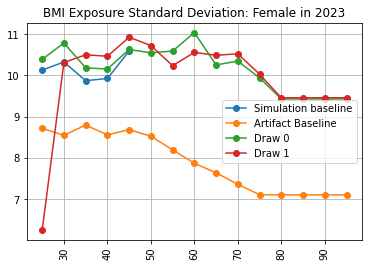

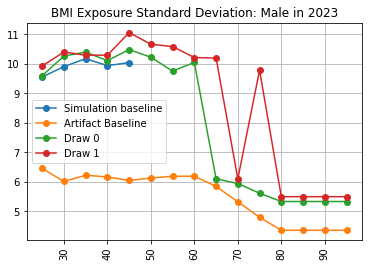

In [30]:
for sex in data1_std.sex.unique():
    plt.figure() 
    subdata = data1_std.loc[(data1_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = bmi_exp_std.loc[(bmi_exp_std.sex==sex.lower()) & (bmi_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    subdata3 = data.loc[(data.sex==sex) & (data.year_end==2020)]
    plt.plot(subdata3['age_start'], subdata3['bmi_std'], marker='o')
    plt.plot(subdata3['age_start'], subdata3['bmi_std_2'], marker='o')
    plt.title(f'BMI Exposure Standard Deviation: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Draw 0', 'Draw 1']) 

This does not look great...

## Relative Risk and PAF Testing 
### First for Myocardial Infarction
Trying the Ali approach first

In [31]:
def load_artifact_key(word:str, cause:str, measure:str):
    data = pd.DataFrame()
    for i in ['alabama']:
        
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25', 'draw==0']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        data = art.load(word + '.' + cause + '.' + measure)
    return data

In [32]:
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
data_MI = data1[['age_start','sex','high_ldl_cholesterol','high_sbp','high_bmi','acute_myocardial_infarction_event_count']]
data_MI['acute_MI_binary'] = np.where(data_MI['acute_myocardial_infarction_event_count'] == 0, 0, 1)
data_MI = data_MI.loc[data_MI['age_start'] > 20]
data_MI.head()

/tmp/ipykernel_1875287/1535174746.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_MI['acute_MI_binary'] = np.where(data_MI['acute_myocardial_infarction_event_count'] == 0, 0, 1)


,age_start,sex,high_ldl_cholesterol,high_sbp,high_bmi,acute_myocardial_infarction_event_count,acute_MI_binary
0,30.0,Female,2.816366,109.351460,34.380091,0,0
1,25.0,Male,4.859210,109.591919,31.007299,0,0
2,35.0,Female,3.497797,120.234550,6.567555,0,0
7,30.0,Male,2.710783,119.045439,24.686512,0,0
8,25.0,Male,3.877427,109.362132,21.501888,0,0


In [33]:
art_MI_inc = load_artifact_key('cause', 'myocardial_infarction', 'incidence_rate')
art_MI_inc = art_MI_inc.rename(columns={"draw_0": "inc"}).reset_index()
art_MI_inc.head()

,sex,age_start,age_end,year_start,year_end,inc
0,Female,25.0,30.0,2019,2020,0.000403
1,Female,30.0,35.0,2019,2020,0.000430
2,Female,35.0,40.0,2019,2020,0.000355
3,Female,40.0,45.0,2019,2020,0.000450
4,Female,45.0,50.0,2019,2020,0.000717


'risk_factor.high_ldl_cholesterol.relative_risk'

'risk_factor.high_ldl_cholesterol.population_attributable_fraction'

In [34]:
art_MI_rr_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'relative_risk')
art_MI_rr_ldl = art_MI_rr_ldl.rename(columns={"draw_0": "rr_ldl"}).reset_index()
art_MI_rr_ldl = art_MI_rr_ldl.loc[art_MI_rr_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_ldl.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_ldl
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0053
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0267
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0483
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.9898
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.8515


In [35]:
art_MI_rr_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'relative_risk')
art_MI_rr_sbp = art_MI_rr_sbp.rename(columns={"draw_0": "rr_sbp"}).reset_index()
art_MI_rr_sbp = art_MI_rr_sbp.loc[art_MI_rr_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_sbp.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_sbp
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0317
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.8558
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.6799
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.5729
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.5348


In [36]:
art_MI_rr_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_MI_rr_bmi = art_MI_rr_bmi.rename(columns={"draw_0": "rr_bmi"}).reset_index()
art_MI_rr_bmi = art_MI_rr_bmi.loc[art_MI_rr_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_bmi.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_bmi
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,3.510608
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.094858
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.685112
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.665879
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.591258


In [37]:
art_MI_paf_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
art_MI_paf_ldl = art_MI_paf_ldl.rename(columns={"draw_0": "paf_ldl"}).reset_index()
art_MI_paf_ldl = art_MI_paf_ldl.loc[art_MI_paf_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_ldl.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_ldl
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.810800
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.813019
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.812301
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.812845
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.777130


In [38]:
art_MI_paf_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
art_MI_paf_sbp = art_MI_paf_sbp.rename(columns={"draw_0": "paf_sbp"}).reset_index()
art_MI_paf_sbp = art_MI_paf_sbp.loc[art_MI_paf_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_sbp.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_sbp
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.276953
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.330705
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.290626
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.431115
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.507418


In [39]:
art_MI_paf_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')
art_MI_paf_bmi = art_MI_paf_bmi.rename(columns={"draw_0": "paf_bmi"}).reset_index()
art_MI_paf_bmi = art_MI_paf_bmi.loc[art_MI_paf_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_bmi.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_bmi
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.986784
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.892493
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.727949
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.715981
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.702021


In [40]:
from get_draws.api import get_draws
rrs_sbp = get_draws(gbd_id_type='rei_id',
               gbd_id=107,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_sbp = rrs_sbp.loc[rrs_sbp.cause_id==493]
rrs_sbp = rrs_sbp[['age_group_id','sex_id','draw_0']]
rrs_sbp['age_start'] = np.where(rrs_sbp['age_group_id']==10,25,np.where(rrs_sbp['age_group_id']==11,30,np.where(rrs_sbp['age_group_id']==12,35,np.where(rrs_sbp['age_group_id']==13,40,np.where(rrs_sbp['age_group_id']==14,45,np.where(rrs_sbp['age_group_id']==15,50,np.where(rrs_sbp['age_group_id']==16,55,np.where(rrs_sbp['age_group_id']==17,60,np.where(rrs_sbp['age_group_id']==18,65,np.where(rrs_sbp['age_group_id']==19,70,np.where(rrs_sbp['age_group_id']==20,75,np.where(rrs_sbp['age_group_id']==30,80,np.where(rrs_sbp['age_group_id']==31,85,np.where(rrs_sbp['age_group_id']==32,90,0))))))))))))))
rrs_sbp['sex'] = np.where(rrs_sbp['sex_id']==1,'Male','Female')
rrs_sbp = rrs_sbp.rename(columns={"draw_0": "rr_gbd_sbp"}).reset_index()
rrs_sbp.head()

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,index,age_group_id,sex_id,rr_gbd_sbp,age_start,sex
0,55,10,1,2.0317,25,Male
1,56,11,1,1.8558,30,Male
2,57,12,1,1.6799,35,Male
3,58,13,1,1.5729,40,Male
4,59,14,1,1.5348,45,Male


In [41]:
rrs = get_draws(gbd_id_type='rei_id',
               gbd_id=367,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs = rrs.loc[rrs.cause_id==493]
rrs = rrs[['age_group_id','sex_id','draw_0']]
rrs['age_start'] = np.where(rrs['age_group_id']==10,25,np.where(rrs['age_group_id']==11,30,np.where(rrs['age_group_id']==12,35,np.where(rrs['age_group_id']==13,40,np.where(rrs['age_group_id']==14,45,np.where(rrs['age_group_id']==15,50,np.where(rrs['age_group_id']==16,55,np.where(rrs['age_group_id']==17,60,np.where(rrs['age_group_id']==18,65,np.where(rrs['age_group_id']==19,70,np.where(rrs['age_group_id']==20,75,np.where(rrs['age_group_id']==30,80,np.where(rrs['age_group_id']==31,85,np.where(rrs['age_group_id']==32,90,0))))))))))))))
rrs['sex'] = np.where(rrs['sex_id']==1,'Male','Female')
rrs = rrs.rename(columns={"draw_0": "rr_gbd_ldl"}).reset_index()
rrs.head()

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,index,age_group_id,sex_id,rr_gbd_ldl,age_start,sex
0,0,10,1,2.0053,25,Male
1,1,11,1,2.0267,30,Male
2,2,12,1,2.0483,35,Male
3,3,13,1,1.9898,40,Male
4,4,14,1,1.8515,45,Male


In [42]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==493]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_0']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_0": "rr_gbd_bmi"}).reset_index()
rrs_bmi.head()

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,index,age_group_id,sex_id,rr_gbd_bmi,age_start,sex
0,47,19,1,1.296208,70,Male
1,48,20,1,1.291149,75,Male
2,49,18,1,1.395200,65,Male
3,50,16,1,1.425974,55,Male
4,51,11,1,2.094858,30,Male


In [43]:
tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5

data_merged = (data_MI.merge(art_MI_inc[['age_start','sex','inc']], on=['age_start','sex'])
               .merge(art_MI_paf_ldl[['age_start','sex','paf_ldl']], on=['age_start','sex'])
               .merge(art_MI_paf_sbp[['age_start','sex','paf_sbp']], on=['age_start','sex'])
               .merge(art_MI_paf_bmi[['age_start','sex','paf_bmi']], on=['age_start','sex'])
              .merge(art_MI_rr_ldl[['age_start','sex','rr_ldl']], on=['age_start','sex'])
              .merge(art_MI_rr_sbp[['age_start','sex','rr_sbp']], on=['age_start','sex'])
              .merge(art_MI_rr_bmi[['age_start','sex','rr_bmi']], on=['age_start','sex'])
              .merge(rrs[['age_start','sex','rr_gbd_ldl']], on=['age_start','sex'])
              .merge(rrs_bmi[['age_start','sex','rr_gbd_bmi']], on=['age_start','sex'])
              .merge(rrs_sbp[['age_start','sex','rr_gbd_sbp']], on=['age_start','sex']))
data_merged['exposure_i_ldl'] = np.where(data_merged.high_ldl_cholesterol < 1, 0, (data_merged.high_ldl_cholesterol - tmrel_ldl))
data_merged['exposure_i_sbp'] = np.where(data_merged.high_sbp < 112.5, 0, (data_merged.high_sbp - tmrel_sbp)/10)
data_merged['exposure_i_bmi'] = np.where(data_merged.high_bmi < tmrel_bmi, 0, (data_merged.high_bmi - tmrel_bmi)/5)
data_merged['rr_i_ldl'] = np.exp(np.log(data_merged.rr_gbd_ldl) * data_merged.exposure_i_ldl)
data_merged['rr_i_sbp'] = np.exp(np.log(data_merged.rr_gbd_sbp) * data_merged.exposure_i_sbp)
data_merged['rr_i_bmi'] = np.exp(np.log(data_merged.rr_gbd_bmi) * data_merged.exposure_i_bmi)
data_merged['inc_i_ldl'] = data_merged.inc * (1 - data_merged.paf_ldl) * data_merged.rr_i_ldl
data_merged['inc_i_sbp'] = data_merged.inc * (1 - data_merged.paf_sbp) * data_merged.rr_i_sbp
data_merged['inc_i_bmi'] = data_merged.inc * (1 - data_merged.paf_bmi) * data_merged.rr_i_bmi
data_merged.head()

,age_start,sex,high_ldl_cholesterol,high_sbp,high_bmi,acute_myocardial_infarction_event_count,acute_MI_binary,inc,paf_ldl,paf_sbp,...,rr_gbd_sbp,exposure_i_ldl,exposure_i_sbp,exposure_i_bmi,rr_i_ldl,rr_i_sbp,rr_i_bmi,inc_i_ldl,inc_i_sbp,inc_i_bmi
0,30.0,Female,2.816366,109.35146,34.380091,0,0,0.00043,0.813019,0.330705,...,1.8558,1.816366,0.0,2.376018,3.607797,1.0,5.795209,0.00029,0.000288,0.000268
1,30.0,Female,2.816366,109.35146,34.380091,0,0,0.00043,0.813019,0.330705,...,1.8558,1.816366,0.0,2.376018,3.607797,1.0,5.795209,0.00029,0.000288,0.000268
2,30.0,Female,2.816366,109.35146,34.380091,0,0,0.00043,0.813019,0.330705,...,1.8558,1.816366,0.0,2.376018,3.607797,1.0,5.795209,0.00029,0.000288,0.000268
3,30.0,Female,2.816366,109.35146,34.380091,0,0,0.00043,0.813019,0.330705,...,1.8558,1.816366,0.0,2.376018,3.607797,1.0,5.795209,0.00029,0.000288,0.000268
4,30.0,Female,2.816366,109.35146,34.380091,0,0,0.00043,0.813019,0.330705,...,1.8558,1.816366,0.0,2.376018,3.607797,1.0,5.795209,0.00029,0.000288,0.000268


In [44]:
data_merged.loc[data_merged['inc_i_bmi']>1]

,age_start,sex,high_ldl_cholesterol,high_sbp,high_bmi,acute_myocardial_infarction_event_count,acute_MI_binary,inc,paf_ldl,paf_sbp,...,rr_gbd_sbp,exposure_i_ldl,exposure_i_sbp,exposure_i_bmi,rr_i_ldl,rr_i_sbp,rr_i_bmi,inc_i_ldl,inc_i_sbp,inc_i_bmi
27580,25.0,Male,2.902548,112.961811,80.000000,0,0,0.000409,0.798182,0.419144,...,2.0317,1.902548,0.046181,11.500000,3.757602,1.033278,1.870238e+06,0.000310,0.000245,14.024607
27581,25.0,Male,2.902548,112.961811,80.000000,0,0,0.000409,0.798182,0.419144,...,2.0317,1.902548,0.046181,11.500000,3.757602,1.033278,1.870238e+06,0.000310,0.000245,14.024607
27582,25.0,Male,2.902548,112.961811,80.000000,0,0,0.000409,0.798182,0.419144,...,2.0317,1.902548,0.046181,11.500000,3.757602,1.033278,1.870238e+06,0.000310,0.000245,14.024607
27583,25.0,Male,2.902548,112.961811,80.000000,0,0,0.000409,0.798182,0.419144,...,2.0317,1.902548,0.046181,11.500000,3.757602,1.033278,1.870238e+06,0.000310,0.000245,14.024607
27584,25.0,Male,2.902548,112.961811,80.000000,0,0,0.000409,0.798182,0.419144,...,2.0317,1.902548,0.046181,11.500000,3.757602,1.033278,1.870238e+06,0.000310,0.000245,14.024607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200832,25.0,Female,2.985114,116.150066,73.802603,0,0,0.000403,0.810800,0.276953,...,2.0317,1.985114,0.365007,10.260521,3.979793,1.295301,3.943726e+05,0.000303,0.000377,2.098602
200833,25.0,Female,2.985114,116.150066,73.802603,0,0,0.000403,0.810800,0.276953,...,2.0317,1.985114,0.365007,10.260521,3.979793,1.295301,3.943726e+05,0.000303,0.000377,2.098602
200834,25.0,Female,2.985114,116.150066,73.802603,0,0,0.000403,0.810800,0.276953,...,2.0317,1.985114,0.365007,10.260521,3.979793,1.295301,3.943726e+05,0.000303,0.000377,2.098602
200835,25.0,Female,2.985114,116.150066,73.802603,0,0,0.000403,0.810800,0.276953,...,2.0317,1.985114,0.365007,10.260521,3.979793,1.295301,3.943726e+05,0.000303,0.000377,2.098602


In [45]:
#data_merged = data_merged.loc[data_merged['inc_i_sbp']<1]
#data_merged = data_merged.loc[data_merged['high_bmi']<70]
p = data_merged.groupby(['sex','age_start','inc']).mean()[['inc_i_ldl','inc_i_sbp','inc_i_bmi']].reset_index()

In [46]:
p.head()

,sex,age_start,inc,inc_i_ldl,inc_i_sbp,inc_i_bmi
0,Female,25.0,0.000403,0.000350,0.000381,0.021305
1,Female,30.0,0.000430,0.000376,0.033240,0.001591
2,Female,35.0,0.000355,0.000289,0.000334,0.000489
3,Female,40.0,0.000450,0.000398,0.001437,0.000598
4,Female,45.0,0.000717,0.000588,0.000763,0.001080


In [59]:
p.loc[p.inc_i_bmi > 0.001]

,sex,age_start,inc,inc_i_ldl,inc_i_sbp,inc_i_bmi
0,Female,25.0,0.000403,0.000350,0.000381,0.021305
4,Female,45.0,0.000717,0.000588,0.000763,0.001080
5,Male,25.0,0.000409,0.000341,0.000371,0.017211
6,Male,30.0,0.000528,0.000442,0.000487,0.001583
8,Male,40.0,0.001091,0.000920,0.001081,0.001584
9,Male,45.0,0.001880,0.001583,0.001790,0.002440


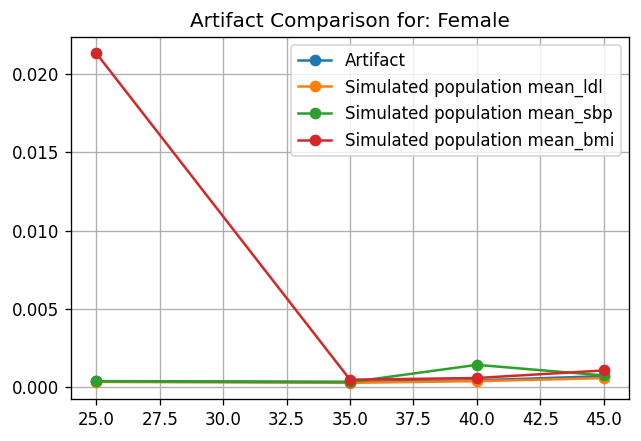

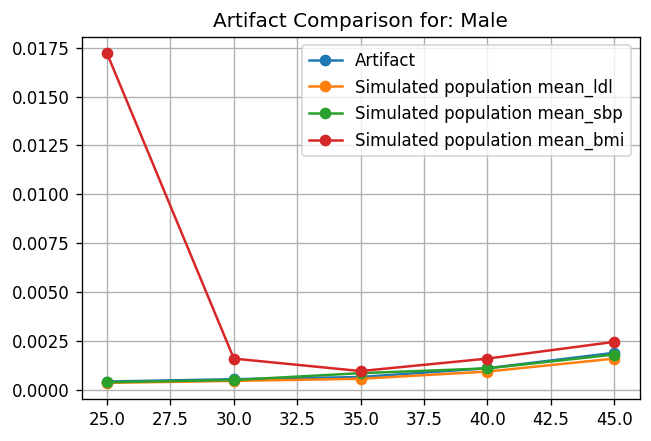

In [55]:
for sex in p.sex.unique():
    plt.figure(dpi=120)
    subdata = p.loc[p.sex == sex]
    plt.plot(subdata.age_start, subdata.inc, marker='o', label='Artifact')
    plt.plot(subdata.age_start, subdata.inc_i_ldl, marker='o', label='Simulated population mean_ldl')
    plt.plot(subdata.age_start, subdata.inc_i_sbp, marker='o', label='Simulated population mean_sbp')
    plt.plot(subdata.age_start, subdata.inc_i_bmi, marker='o', label='Simulated population mean_bmi')
    plt.legend()
    plt.title(f'Artifact Comparison for: {sex}') 
    plt.grid()

It does look like there might be something weird going on in the youngest age group here. Also, I need to check on this TMREL

## Same approach for stroke

In [47]:
data_stroke = data1[['age_start','sex','high_ldl_cholesterol','high_sbp','high_bmi','acute_ischemic_stroke_event_count']]
data_stroke = data_stroke.loc[data_stroke['age_start'] > 20]
data_stroke.head()

,age_start,sex,high_ldl_cholesterol,high_sbp,high_bmi,acute_ischemic_stroke_event_count
0,30.0,Female,2.816366,109.351460,34.380091,0
1,25.0,Male,4.859210,114.142950,31.007299,0
2,35.0,Female,3.497797,120.234550,6.567555,0
7,30.0,Male,2.710783,119.045439,24.686512,0
8,25.0,Male,3.877427,109.362132,21.501888,0


In [48]:
art_stroke_inc = load_artifact_key('cause', 'ischemic_stroke', 'incidence_rate')
art_stroke_inc = art_stroke_inc.rename(columns={"draw_0": "inc"}).reset_index()
art_stroke_inc.head()

,sex,age_start,age_end,year_start,year_end,inc
0,Female,25.0,30.0,2019,2020,0.000088
1,Female,30.0,35.0,2019,2020,0.000131
2,Female,35.0,40.0,2019,2020,0.000199
3,Female,40.0,45.0,2019,2020,0.000389
4,Female,45.0,50.0,2019,2020,0.000703


In [49]:
art_stroke_rr_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'relative_risk')
art_stroke_rr_ldl = art_stroke_rr_ldl.rename(columns={"draw_0": "rr_ldl"}).reset_index()
art_stroke_rr_ldl = art_stroke_rr_ldl.loc[art_stroke_rr_ldl['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_ldl.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_ldl
90,Female,25.0,30.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.4165
91,Female,30.0,35.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.4715
92,Female,35.0,40.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.5265
93,Female,40.0,45.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.5155
94,Female,45.0,50.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.4385


In [50]:
art_stroke_rr_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'relative_risk')
art_stroke_rr_sbp = art_stroke_rr_sbp.rename(columns={"draw_0": "rr_sbp"}).reset_index()
art_stroke_rr_sbp = art_stroke_rr_sbp.loc[art_stroke_rr_sbp['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_sbp.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_sbp
90,Female,25.0,30.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.7644
91,Female,30.0,35.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.7026
92,Female,35.0,40.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.6409
93,Female,40.0,45.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.5878
94,Female,45.0,50.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.5435


In [51]:
art_stroke_rr_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_stroke_rr_bmi = art_stroke_rr_bmi.rename(columns={"draw_0": "rr_bmi"}).reset_index()
art_stroke_rr_bmi = art_stroke_rr_bmi.loc[art_stroke_rr_bmi['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_bmi.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_bmi
90,Female,25.0,30.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,2.405075
91,Female,30.0,35.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,2.220086
92,Female,35.0,40.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.919950
93,Female,40.0,45.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.738278
94,Female,45.0,50.0,2019,2020,acute_ischemic_stroke,incidence_rate,per unit,1.809969


In [52]:
art_stroke_paf_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
art_stroke_paf_ldl = art_stroke_paf_ldl.rename(columns={"draw_0": "paf_ldl"}).reset_index()
art_stroke_paf_ldl = art_stroke_paf_ldl.loc[art_stroke_paf_ldl['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_ldl.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_ldl
90,Female,25.0,30.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.547415
91,Female,30.0,35.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.583508
92,Female,35.0,40.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.608706
93,Female,40.0,45.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.622023
94,Female,45.0,50.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.573479


In [53]:
art_stroke_paf_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
art_stroke_paf_sbp = art_stroke_paf_sbp.rename(columns={"draw_0": "paf_sbp"}).reset_index()
art_stroke_paf_sbp = art_stroke_paf_sbp.loc[art_stroke_paf_sbp['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_sbp.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_sbp
90,Female,25.0,30.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.216149
91,Female,30.0,35.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.281803
92,Female,35.0,40.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.276264
93,Female,40.0,45.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.439278
94,Female,45.0,50.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.513140


In [54]:
art_stroke_paf_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')
art_stroke_paf_bmi = art_stroke_paf_bmi.rename(columns={"draw_0": "paf_bmi"}).reset_index()
art_stroke_paf_bmi = art_stroke_paf_bmi.loc[art_stroke_paf_bmi['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_bmi.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_bmi
90,Female,25.0,30.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.929901
91,Female,30.0,35.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.914644
92,Female,35.0,40.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.824510
93,Female,40.0,45.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.752170
94,Female,45.0,50.0,2019,2020,acute_ischemic_stroke,incidence_rate,0.807025


In [55]:
rrs_sbp = get_draws(gbd_id_type='rei_id',
               gbd_id=107,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_sbp = rrs_sbp.loc[rrs_sbp.cause_id==495]
rrs_sbp = rrs_sbp[['age_group_id','sex_id','draw_0']]
rrs_sbp['age_start'] = np.where(rrs_sbp['age_group_id']==10,25,np.where(rrs_sbp['age_group_id']==11,30,np.where(rrs_sbp['age_group_id']==12,35,np.where(rrs_sbp['age_group_id']==13,40,np.where(rrs_sbp['age_group_id']==14,45,np.where(rrs_sbp['age_group_id']==15,50,np.where(rrs_sbp['age_group_id']==16,55,np.where(rrs_sbp['age_group_id']==17,60,np.where(rrs_sbp['age_group_id']==18,65,np.where(rrs_sbp['age_group_id']==19,70,np.where(rrs_sbp['age_group_id']==20,75,np.where(rrs_sbp['age_group_id']==30,80,np.where(rrs_sbp['age_group_id']==31,85,np.where(rrs_sbp['age_group_id']==32,90,0))))))))))))))
rrs_sbp['sex'] = np.where(rrs_sbp['sex_id']==1,'Male','Female')
rrs_sbp = rrs_sbp.rename(columns={"draw_0": "rr_gbd_sbp"}).reset_index()
rrs_sbp.head()

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,index,age_group_id,sex_id,rr_gbd_sbp,age_start,sex
0,110,10,1,1.7644,25,Male
1,111,11,1,1.7026,30,Male
2,112,12,1,1.6409,35,Male
3,113,13,1,1.5878,40,Male
4,114,14,1,1.5435,45,Male


In [56]:
rrs = get_draws(gbd_id_type='rei_id',
               gbd_id=367,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs = rrs.loc[rrs.cause_id==495]
rrs = rrs[['age_group_id','sex_id','draw_0']]
rrs['age_start'] = np.where(rrs['age_group_id']==10,25,np.where(rrs['age_group_id']==11,30,np.where(rrs['age_group_id']==12,35,np.where(rrs['age_group_id']==13,40,np.where(rrs['age_group_id']==14,45,np.where(rrs['age_group_id']==15,50,np.where(rrs['age_group_id']==16,55,np.where(rrs['age_group_id']==17,60,np.where(rrs['age_group_id']==18,65,np.where(rrs['age_group_id']==19,70,np.where(rrs['age_group_id']==20,75,np.where(rrs['age_group_id']==30,80,np.where(rrs['age_group_id']==31,85,np.where(rrs['age_group_id']==32,90,0))))))))))))))
rrs['sex'] = np.where(rrs['sex_id']==1,'Male','Female')
rrs = rrs.rename(columns={"draw_0": "rr_gbd_ldl"}).reset_index()
rrs.head()

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,index,age_group_id,sex_id,rr_gbd_ldl,age_start,sex
0,11,10,1,1.4165,25,Male
1,12,11,1,1.4715,30,Male
2,13,12,1,1.5265,35,Male
3,14,13,1,1.5155,40,Male
4,15,14,1,1.4385,45,Male


In [57]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==495]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_0']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_0": "rr_gbd_bmi"}).reset_index()
rrs_bmi.head()

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,index,age_group_id,sex_id,rr_gbd_bmi,age_start,sex
0,69,12,1,1.919950,35,Male
1,70,15,1,1.727334,50,Male
2,71,14,1,1.809969,45,Male
3,72,17,1,1.497946,60,Male
4,73,10,1,2.405075,25,Male


In [58]:
tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5

data_merged = (data_stroke.merge(art_stroke_inc[['age_start','sex','inc']], on=['age_start','sex'])
               .merge(art_stroke_paf_ldl[['age_start','sex','paf_ldl']], on=['age_start','sex'])
               .merge(art_stroke_paf_sbp[['age_start','sex','paf_sbp']], on=['age_start','sex'])
               .merge(art_stroke_paf_bmi[['age_start','sex','paf_bmi']], on=['age_start','sex'])
              .merge(art_stroke_rr_ldl[['age_start','sex','rr_ldl']], on=['age_start','sex'])
              .merge(art_stroke_rr_sbp[['age_start','sex','rr_sbp']], on=['age_start','sex'])
              .merge(art_stroke_rr_bmi[['age_start','sex','rr_bmi']], on=['age_start','sex'])
              .merge(rrs[['age_start','sex','rr_gbd_ldl']], on=['age_start','sex'])
              .merge(rrs_bmi[['age_start','sex','rr_gbd_bmi']], on=['age_start','sex'])
              .merge(rrs_sbp[['age_start','sex','rr_gbd_sbp']], on=['age_start','sex']))
data_merged['exposure_i_ldl'] = np.where(data_merged.high_ldl_cholesterol < 1, 0, (data_merged.high_ldl_cholesterol - tmrel_ldl))
data_merged['exposure_i_sbp'] = np.where(data_merged.high_sbp < 112.5, 0, (data_merged.high_sbp - tmrel_sbp)/10)
data_merged['exposure_i_bmi'] = np.where(data_merged.high_bmi < tmrel_bmi, 0, (data_merged.high_bmi - tmrel_bmi)/5)
data_merged['rr_i_ldl'] = np.exp(np.log(data_merged.rr_gbd_ldl) * data_merged.exposure_i_ldl)
data_merged['rr_i_sbp'] = np.exp(np.log(data_merged.rr_gbd_sbp) * data_merged.exposure_i_sbp)
data_merged['rr_i_bmi'] = np.exp(np.log(data_merged.rr_gbd_bmi) * data_merged.exposure_i_bmi)
data_merged['inc_i_ldl'] = data_merged.inc * (1 - data_merged.paf_ldl) * data_merged.rr_i_ldl
data_merged['inc_i_sbp'] = data_merged.inc * (1 - data_merged.paf_sbp) * data_merged.rr_i_sbp
data_merged['inc_i_bmi'] = data_merged.inc * (1 - data_merged.paf_bmi) * data_merged.rr_i_bmi
data_merged.head()

,age_start,sex,high_ldl_cholesterol,high_sbp,high_bmi,acute_ischemic_stroke_event_count,inc,paf_ldl,paf_sbp,paf_bmi,...,rr_gbd_sbp,exposure_i_ldl,exposure_i_sbp,exposure_i_bmi,rr_i_ldl,rr_i_sbp,rr_i_bmi,inc_i_ldl,inc_i_sbp,inc_i_bmi
0,30.0,Female,2.816366,109.35146,34.380091,0,0.000131,0.583508,0.281803,0.914644,...,1.7026,1.816366,0.0,2.376018,2.017038,1.0,6.652441,0.00011,0.000094,0.000074
1,30.0,Female,2.816366,109.35146,34.380091,0,0.000131,0.583508,0.281803,0.914644,...,1.7026,1.816366,0.0,2.376018,2.017038,1.0,6.652441,0.00011,0.000094,0.000074
2,30.0,Female,2.816366,109.35146,34.380091,0,0.000131,0.583508,0.281803,0.914644,...,1.7026,1.816366,0.0,2.376018,2.017038,1.0,6.652441,0.00011,0.000094,0.000074
3,30.0,Female,2.816366,109.35146,34.380091,0,0.000131,0.583508,0.281803,0.914644,...,1.7026,1.816366,0.0,2.376018,2.017038,1.0,6.652441,0.00011,0.000094,0.000074
4,30.0,Female,2.816366,109.35146,34.380091,0,0.000131,0.583508,0.281803,0.914644,...,1.7026,1.816366,0.0,2.376018,2.017038,1.0,6.652441,0.00011,0.000094,0.000074


In [59]:
data_merged = data_merged.loc[data_merged['inc_i_sbp']<1]
p = data_merged.groupby(['sex','age_start','inc']).mean()[['inc_i_ldl','inc_i_sbp','inc_i_bmi']].reset_index()

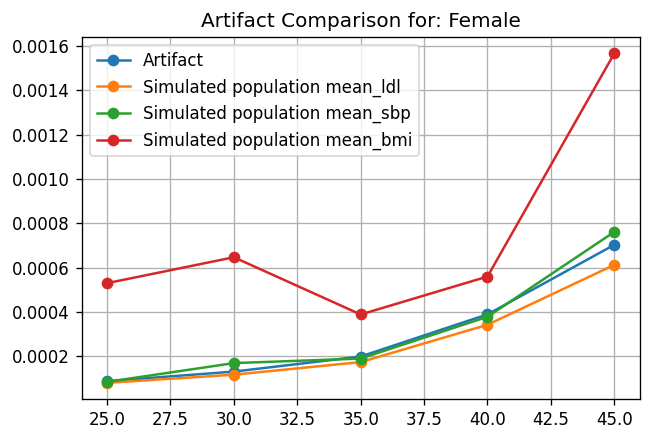

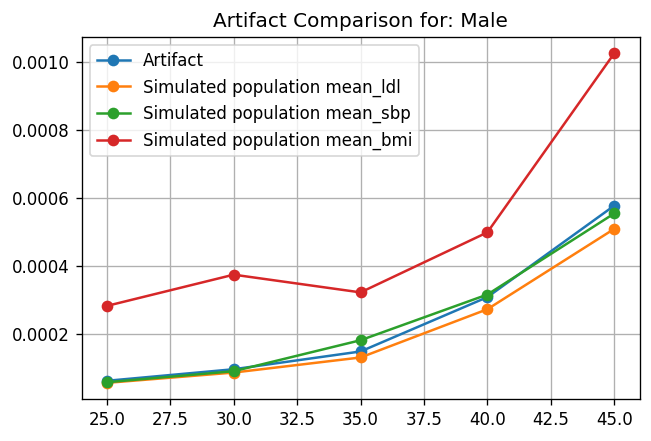

In [60]:
for sex in p.sex.unique():
    plt.figure(dpi=120)
    subdata = p.loc[p.sex == sex]
    plt.plot(subdata.age_start, subdata.inc, marker='o', label='Artifact')
    plt.plot(subdata.age_start, subdata.inc_i_ldl, marker='o', label='Simulated population mean_ldl')
    plt.plot(subdata.age_start, subdata.inc_i_sbp, marker='o', label='Simulated population mean_sbp')
    plt.plot(subdata.age_start, subdata.inc_i_bmi, marker='o', label='Simulated population mean_bmi')
    plt.legend()
    plt.title(f'Artifact Comparison for: {sex}') 
    plt.grid()

Less here, this matches with what we saw in the other notebook - MI is more worrisome 

## Below this IS NOT UPDATED for this model at this time 

## Regression Model Using Incidence Values, not Many Time Steps

#### First for MI and LDL

In [61]:
data_MI_regression = data1[['age_start','sex','high_ldl_cholesterol','high_sbp','acute_mi','acute_stroke','angina_inc']]
data_MI_regression['sbp_exposure'] = np.where(data_MI_regression.high_sbp < 112.5, 0, (data_MI_regression.high_sbp - 112.5)/10)
data_MI_regression.head()

KeyError: "['angina_inc'] not in index"

In [ ]:
data_MI_regression = data_MI_regression.loc[(data_MI_regression['age_start']>20) & (data_MI_regression['age_start']<95) & (data_MI_regression['high_sbp']<290)]

In [ ]:
df = pd.DataFrame() 
for sex in data_MI_regression.sex.unique():
    for age in data_MI_regression.age_start.unique():
        current_data = data_MI_regression.loc[(data_MI_regression['age_start']==age) & (data_MI_regression['sex']==sex)]
        model = smf.logit("acute_mi ~ high_ldl_cholesterol", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

In [ ]:
df = df.loc[df.index=='high_ldl_cholesterol']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

In [ ]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [ ]:
rel_risk = art.load('risk_factor.high_ldl_cholesterol.relative_risk')
ldl_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
ldl_rr_mi = ldl_rr.loc[ldl_rr['affected_entity']=='acute_myocardial_infarction']
ldl_rr_mi.head()

In [ ]:
with PdfPages('MI_ldlc_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = ldl_rr_mi.loc[ldl_rr_mi['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of MI from LDL-C: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### Now for Stroke with LDL-C

In [ ]:
df = pd.DataFrame() 
for sex in data_MI_regression.sex.unique():
    for age in data_MI_regression.age_start.unique():
        current_data = data_MI_regression.loc[(data_MI_regression['age_start']==age) & (data_MI_regression['sex']==sex)]
        model = smf.logit("acute_stroke ~ high_ldl_cholesterol", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

In [ ]:
df = df.loc[df.index=='high_ldl_cholesterol']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

In [ ]:
ldl_rr_stroke = ldl_rr.loc[ldl_rr['affected_entity']=='acute_ischemic_stroke']

In [ ]:
with PdfPages('stroke_ldlc_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = ldl_rr_stroke.loc[ldl_rr_stroke['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.legend()
        plt.title(f'Relative risk of Stroke from LDL-C: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### Now with MI and SBP

In [ ]:
data_MI_regression = data_MI_regression.loc[data_MI_regression['age_start']<95]
df = pd.DataFrame() 
for sex in data_MI_regression.sex.unique():
    for age in data_MI_regression.age_start.unique():
        current_data = data_MI_regression.loc[(data_MI_regression['age_start']==age) & (data_MI_regression['sex']==sex)]
        model = smf.logit("acute_mi ~ sbp_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

In [ ]:
df = df.loc[df.index=='sbp_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

In [ ]:
rel_risk = art.load('risk_factor.high_systolic_blood_pressure.relative_risk')
sbp_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
sbp_rr_mi = sbp_rr.loc[sbp_rr['affected_entity']=='acute_myocardial_infarction']
sbp_rr_mi.head()

In [ ]:
with PdfPages('MI_sbp_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = sbp_rr_mi.loc[sbp_rr_mi['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.legend()
        plt.title(f'Relative risk of MI from SBP: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### Stroke for SBP

In [ ]:
data_MI_regression = data_MI_regression.loc[data_MI_regression['age_start']<95]
df = pd.DataFrame() 
for sex in data_MI_regression.sex.unique():
    for age in data_MI_regression.age_start.unique():
        current_data = data_MI_regression.loc[(data_MI_regression['age_start']==age) & (data_MI_regression['sex']==sex)]
        model = smf.logit("acute_stroke ~ sbp_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

In [ ]:
df = df.loc[df.index=='sbp_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

In [ ]:
sbp_rr_stroke = sbp_rr.loc[sbp_rr['affected_entity']=='acute_myocardial_infarction']
sbp_rr_stroke.head()

In [ ]:
with PdfPages('stroke_sbp_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = sbp_rr_stroke.loc[sbp_rr_stroke['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of Stroke from SBP: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### Angina with SBP

In [ ]:
data_MI_regression = data_MI_regression.loc[(data_MI_regression['age_start']<95) & (data_MI_regression['age_start']>20)]
df = pd.DataFrame() 
for sex in data_MI_regression.sex.unique():
    for age in data_MI_regression.age_start.unique():
        current_data = data_MI_regression.loc[(data_MI_regression['age_start']==age) & (data_MI_regression['sex']==sex)]
        model = smf.logit("angina_inc ~ sbp_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

In [ ]:
df = df.loc[df.index=='sbp_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

In [ ]:
rel_risk = art.load('risk_factor.high_systolic_blood_pressure.relative_risk')
sbp_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
sbp_rr_angina = sbp_rr.loc[sbp_rr['affected_entity']=='angina']
sbp_rr_angina.head()

In [ ]:
for sex in df.sex.unique():
    plt.figure(dpi=120)
    subdata = sbp_rr_angina.loc[sbp_rr_angina['sex']==sex]
    plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
    subdata2 = df.loc[df['sex']==sex]
    plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
    plt.legend()
    plt.grid()

### Angina with LDL-C

In [ ]:
data_MI_regression = data_MI_regression.loc[(data_MI_regression['age_start']<95) & (data_MI_regression['age_start']>20)]
df = pd.DataFrame() 
for sex in data_MI_regression.sex.unique():
    for age in data_MI_regression.age_start.unique():
        current_data = data_MI_regression.loc[(data_MI_regression['age_start']==age) & (data_MI_regression['sex']==sex)]
        model = smf.logit("angina_inc ~ high_ldl_cholesterol", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

In [ ]:
df = df.loc[df.index=='high_ldl_cholesterol']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

In [ ]:
rel_risk = art.load('risk_factor.high_ldl_cholesterol.relative_risk')
ldl_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
ldl_rr_angina = ldl_rr.loc[ldl_rr['affected_entity']=='angina']
ldl_rr_angina.head()

In [ ]:
for sex in df.sex.unique():
    plt.figure(dpi=120)
    subdata = ldl_rr_angina.loc[ldl_rr_angina['sex']==sex]
    plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
    subdata2 = df.loc[df['sex']==sex]
    plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
    plt.legend()
    plt.grid()

## Testing for Overlap of Angina and MI

In [ ]:
sim_data = pd.DataFrame()
for step in list(range(0,100)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t], axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])

In [ ]:
sim_data_time99 = sim_data.loc[sim_data['step'] == 99]

In [ ]:
len(sim_data_time99.loc[(sim_data_time99.angina =='angina') & (sim_data_time99.acute_myocardial_infarction_event_count > 0)])

In [ ]:
len(sim_data_time99.loc[(sim_data_time99.angina =='angina') | (sim_data_time99.acute_myocardial_infarction_event_count > 0)])

In [ ]:
len(sim_data_time99.loc[(sim_data_time99.angina =='angina')])

In [ ]:
len(sim_data_time99.loc[(sim_data_time99.acute_myocardial_infarction_event_count > 0)])

In [ ]:
8/(288+88)